## Описание и постановка задачи

*Farpost запустил скрытую базу объявлений в недвижимости в задаче BZR-24274. 
Хочется понять эффект от внедрения скрытой базы.*

**В чем суть скрытой базы?**

На барахолке существуют агенты из белого списка - это различного рода компании и агенства, занимающиеся недвижимостью. Им дают доступ в скрытую базу: можно бесплатно подать, перенести объявления. База видна только им. Перспектива скрытой базы в дальнейшей монетизации.

**Задачи**

Что с *частниками*?

 - сколько людей подало в скрытую базу: в какие разделы, количество по неделям, распределение эффекта новизны;
 
 - сколько людей, которые никогда не подавали объявление в недвижимости, подали в скрытую базу;
 
 - сколько людей, которые зависали раньше на черновике в недвижимости, подали в скрытую базу;
 
Что с *агентами*?

 - звонят ли по объявлениям, какая конверсия

Что с *датасетом*?

 - стало ли меньше черновиков? гипотеза в том, что люди, которых раньше останавливала цена, стали публиковать в скрытую базу;
 
 - стало ли больше удаленных? судя по фидбэкам, есть вероятность, что скрытая база не оправдывает пользовательские ожидания и пользователи удаляют объявления;

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

import scipy.stats as st
import math

# 1. Что с частниками ?

## 1.1. Извлечение разделов недвижимости

Для написания запроса на выборку данных, необходимы названия и id разделов. 
Для этого необходимо парсить дерево разделов (большой json)

In [1]:
import urllib
import json

def extract_dirs(host, attrs):
    
    def parse(json, parent_id=None, full_path=None, full_title=None):
        lst = {'id': json['id'], 'dir_type': 'real', 'parent_id': parent_id}
        
        for k in attrs:
            if k in json:
                lst[k] = json[k]
    #-------------------------------
        if 'urlPart' in json:
            lst['url'] = json['urlPart']

        else:
            lst['url'] = ''
    #------------------
        if full_path == None:
            lst['full_path'] = '/'
        else: 
            lst['full_path'] = full_path + '/' + lst['url'] + '/'
    #-----------------
        if full_title==None:
            lst['full_title'] = '/'
        else:
            lst['full_title'] = full_title + '/' + lst['title'] + '/'
    #-------------------------------

        yield lst
        
        if 'children' in json and len(json['children'])>0:
            for c in json['children']:
                yield from parse(c, lst['id'], lst['full_path'][:-1], lst['full_title'][:-1])

        if 'merged' in json:

            for l in json['merged']:
                lst2 = lst.copy()
                lst2['dir_type'] = 'merged'
                
                lst2['id'] = l

                yield lst2

    attr_join = ','.join(attrs)
    path = f'https://{host}/export/dirs_with_attributes?attrs={attr_join}'
    
    with urllib.request.urlopen(path) as url:
        data = json.loads(url.read().decode())
    
        return pd.DataFrame([i for i in parse(data)])

In [11]:
# Результаты парсинга
dirs = extract_dirs('www.farpost.ru', ['title', 'isSelling'])
dirs.head()

,dir_type,full_path,full_title,id,isSelling,parent_id,title,url
0,real,/,/,0,NaN,NaN,Фарпост,
1,real,/auto/,/Авто и мото/,4,NaN,0.0,Авто и мото,auto
2,real,/auto/sale/,/Авто и мото/Продажа легковых автомобилей/,12,1,4.0,Продажа легковых автомобилей,sale
3,real,/auto/spares/,/Авто и мото/Автомобили на запчасти/,184,NaN,4.0,Автомобили на запчасти,spares
4,real,/auto/sell_spare_parts/,/Авто и мото/Автозапчасти/,14,1,4.0,Автозапчасти,sell_spare_parts


Фича работает только в недвижимости и не работает в разделах: projects, buy, flat_wanted, abroad.

Поэтому

In [17]:
# Оставляем только недвижимость
realty_only = dirs[dirs['full_path'].str.contains(r'^/realty/')]

# Убираем разделы, в которых отсутствует фича + убрал realty, так как
# по всей недвижимости будем анализировать просто все разделы
not_in_test = ['projects', 'buy', 'flat_wanted', 'abroad', 'realty']
tested_dir = realty_only[~realty_only['url'].isin(not_in_test)]

tested_dir.head()

,dir_type,full_path,full_title,id,isSelling,parent_id,title,url
220,real,/realty/sell_flats/,/Недвижимость/Продажа квартир/,35,1,7.0,Продажа квартир,sell_flats
221,real,/realty/rent_flats/,/Недвижимость/Аренда квартир/,36,1,7.0,Аренда квартир,rent_flats
222,real,/realty/rent-apartment/,/Недвижимость/Квартиры посуточно/,806,1,7.0,Квартиры посуточно,rent-apartment
224,real,/realty/exchange/,/Недвижимость/Обмен недвижимости/,37,NaN,7.0,Обмен недвижимости,exchange
226,real,/realty/sell_houses/,"/Недвижимость/Продажа домов, коттеджей и дач/",40,1,7.0,"Продажа домов, коттеджей и дач",sell_houses


In [13]:
# ids полученных разделов
str_ids = ','.join(list(map(lambda x: str(x), tested_dir['id'])))
str_ids

'35,36,806,37,42,40,415,41,140,652,38,39,478,481,480,479,483,482,238,837'

В запросе группируем некоторые разделы для удобства.
Например WHEN id in (39, 482, 479, 483, 478, 480, 481) THEN 39

Поэтому из таблицы следует убрать значения (482, 479, 483, 478, 480, 481)

Потому что далее она будет использоваться для мерджа по id и сопоставления разделов

In [24]:
# Убираем все разделы, которые заменены в запросе attrs, кроме первых
groups = [482, 479, 483, 478, 480, 481, 42, 415]

dirs = tested_dir[~tested_dir['id'].isin(groups)]
dirs.head()

,dir_type,full_path,full_title,id,isSelling,parent_id,title,url
220,real,/realty/sell_flats/,/Недвижимость/Продажа квартир/,35,1,7.0,Продажа квартир,sell_flats
221,real,/realty/rent_flats/,/Недвижимость/Аренда квартир/,36,1,7.0,Аренда квартир,rent_flats
222,real,/realty/rent-apartment/,/Недвижимость/Квартиры посуточно/,806,1,7.0,Квартиры посуточно,rent-apartment
224,real,/realty/exchange/,/Недвижимость/Обмен недвижимости/,37,NaN,7.0,Обмен недвижимости,exchange
226,real,/realty/sell_houses/,"/Недвижимость/Продажа домов, коттеджей и дач/",40,1,7.0,"Продажа домов, коттеджей и дач",sell_houses


## 1.2 сколько людей подало в скрытую базу

In [16]:
import numpy as np

In [99]:
datelist = pd.date_range(start='2019-03-28', end='2019-06-15').strftime("%Y-%m-%d").tolist()
DATE = dict(enumerate(datelist))

**Запрос по разделам (attrs)**

В запросе выбираем dir (id раздела), считаем всех уникальных пользователей и считаем уникальных ползователей если атрибут isPrivate = 1, т.е. приватная база (из колонки с xml документами - attributes)

dir должен быть среди ранее выбранных id (str_ids)

город, в котором есть фича - Владивосток (cityid = 1)

Также исключаем админов с помощью подзапроса

Объявления должны быть не черновиками и валидными(заполненными): !='paymentRequired' и is_valid = 1

In [1299]:
import mysql.connector

cnx = mysql.connector.connect(option_files='/etc/my.cnf')
cursor = cnx.cursor()

for d in DATE:
    
    attrs = f"""
    SELECT
    
    DATE(date_created) AS dt,
    
    CASE
    WHEN dir in (39, 482, 479, 483, 478, 480, 481) THEN 39
    WHEN dir in (37, 42) THEN 37
    WHEN dir in (40, 415) THEN 40
    ELSE dir
    END as dirs,
    
    COUNT(DISTINCT reg_user_id),
    COUNT(DISTINCT CASE WHEN EXTRACTVALUE(attributes,'/attributes/attribute[@name="bulletin.isPrivate"]/@value') IN ('1' , 'true') THEN reg_user_id ELSE null END)
    

    FROM bazar.bulletins
    
    WHERE dir IN ({str_ids})
    
        AND cityid = 1
    
        AND reg_user_id not in 
        (
        SELECT
            user_id
        FROM
            bazar.user_roles
        WHERE
            role = 'admin'
        )
    
        AND payment_status != 'paymentRequired'
        AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
    
        AND date_created >= '{DATE[d]} 00:00:00'
        AND date_created <= '{DATE[d]} 23:59:59'
    
    GROUP BY dt, dirs
    """
    
    cursor.execute(attrs)
    pd.DataFrame([i for i in cursor], columns=['date', 'dirs', 'user_cnt', 'priv_cnt']).to_csv('/home/starkov/FANS/FAN58/attrs/' + DATE[d] + '.csv')

In [34]:
priv_base_num = pd.concat([pd.read_csv('/home/starkov/FANS/FAN58/attrs/' + DATE[d] + '.csv') for d in DATE])

In [35]:
priv_base_num.head(2)

,Unnamed: 0,date,dirs,user_cnt,priv_cnt
0,0,2019-03-01,35,46,0
1,1,2019-03-01,36,43,0


**Запрос по всей недвижимости (realty)**

In [1311]:
for d in DATE:
    
    realty = f"""
    SELECT
    
    DATE(date_created) AS dt,
    
    COUNT(DISTINCT reg_user_id),
    COUNT(CASE WHEN EXTRACTVALUE(attributes,'/attributes/attribute[@name="bulletin.isPrivate"]/@value') IN ('1' , 'true') THEN reg_user_id ELSE null END)

    FROM bazar.bulletins
    
    WHERE dir IN ({str_ids})
    
        AND cityid = 1
    
        AND reg_user_id not in 
        (
        SELECT
            user_id
        FROM
            bazar.user_roles
        WHERE
            role = 'admin'
        )
    
        AND payment_status != 'paymentRequired'
        AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
    
        AND date_created >= '{DATE[d]} 00:00:00'
        AND date_created <= '{DATE[d]} 23:59:59'
    
    GROUP BY dt
    
    """
    
    cursor.execute(realty)
    pd.DataFrame([i for i in cursor], columns=['date', 'user_cnt', 'priv_cnt']).to_csv('/home/starkov/FANS/FAN58/realty/' + DATE[d] + '.csv')

In [36]:
priv_base_num_all = pd.concat([pd.read_csv('/home/starkov/FANS/FAN58/realty/' + DATE[d] + '.csv') for d in DATE])

In [37]:
priv_base_num_all.head(2)

,Unnamed: 0,date,user_cnt,priv_cnt
0,0,2019-03-01,120,0
0,0,2019-03-02,63,0


**Обработка данных с запросов**

In [38]:
priv_base_num_all.drop(priv_base_num_all.columns[0], inplace=True, axis=1)
priv_base_num_all.set_index('date', inplace=True)
priv_base_num_all.index = pd.to_datetime(priv_base_num_all.index)

priv_base_num.rename(index=str, columns={"dirs": "id"}, inplace=True)
priv_base_num.drop(priv_base_num.columns[0], inplace=True, axis=1)

Группируем по дате и выполняем right join для данных с запроса attr и dirs (выбирали из дерева разделов) по id

в rez попадают все разделы в том же порядке что и dirs по дням (см. title)

title - это названия разделов, связанные с id в dirs. Решейпнули для рисования в subplot

In [65]:
rez = priv_base_num.groupby('date').apply(lambda x: x[['id',
                                                       'user_cnt',
                                                       'priv_cnt']].merge(dirs['id'].to_frame(),
                                                                          on='id',
                                                                          how='right').fillna(0, downcast='infer')
                                         )

rez.index = rez.index.droplevel(1)
rez.index = pd.to_datetime(rez.index)

r_id = np.array(dirs['id']).reshape(-1, 2)
title = np.array(dirs['title']).reshape(-1, 2)

rez.columns = ['id', 'Подавшие объявления', 'Подавшие объявления в скрытую базу']

In [66]:
title

array([['Продажа квартир', 'Аренда квартир'],
       ['Квартиры посуточно', 'Обмен недвижимости'],
       ['Продажа домов, коттеджей и дач', 'Аренда домов и коттеджей'],
       ['Продажа земельных участков', 'Аренда земельных участков'],
       ['Продажа помещений', 'Аренда помещений'],
       ['Продажа гаражей', 'Аренда гаражей']], dtype=object)

In [67]:
rez.head()

,id,Подавшие объявления,Подавшие объявления в скрытую базу
date,,,
2019-03-01,35,46,0
2019-03-01,36,43,0
2019-03-01,38,3,0
2019-03-01,39,14,0
2019-03-01,40,6,0


Пробегаем по всем разделам и соответствующим title

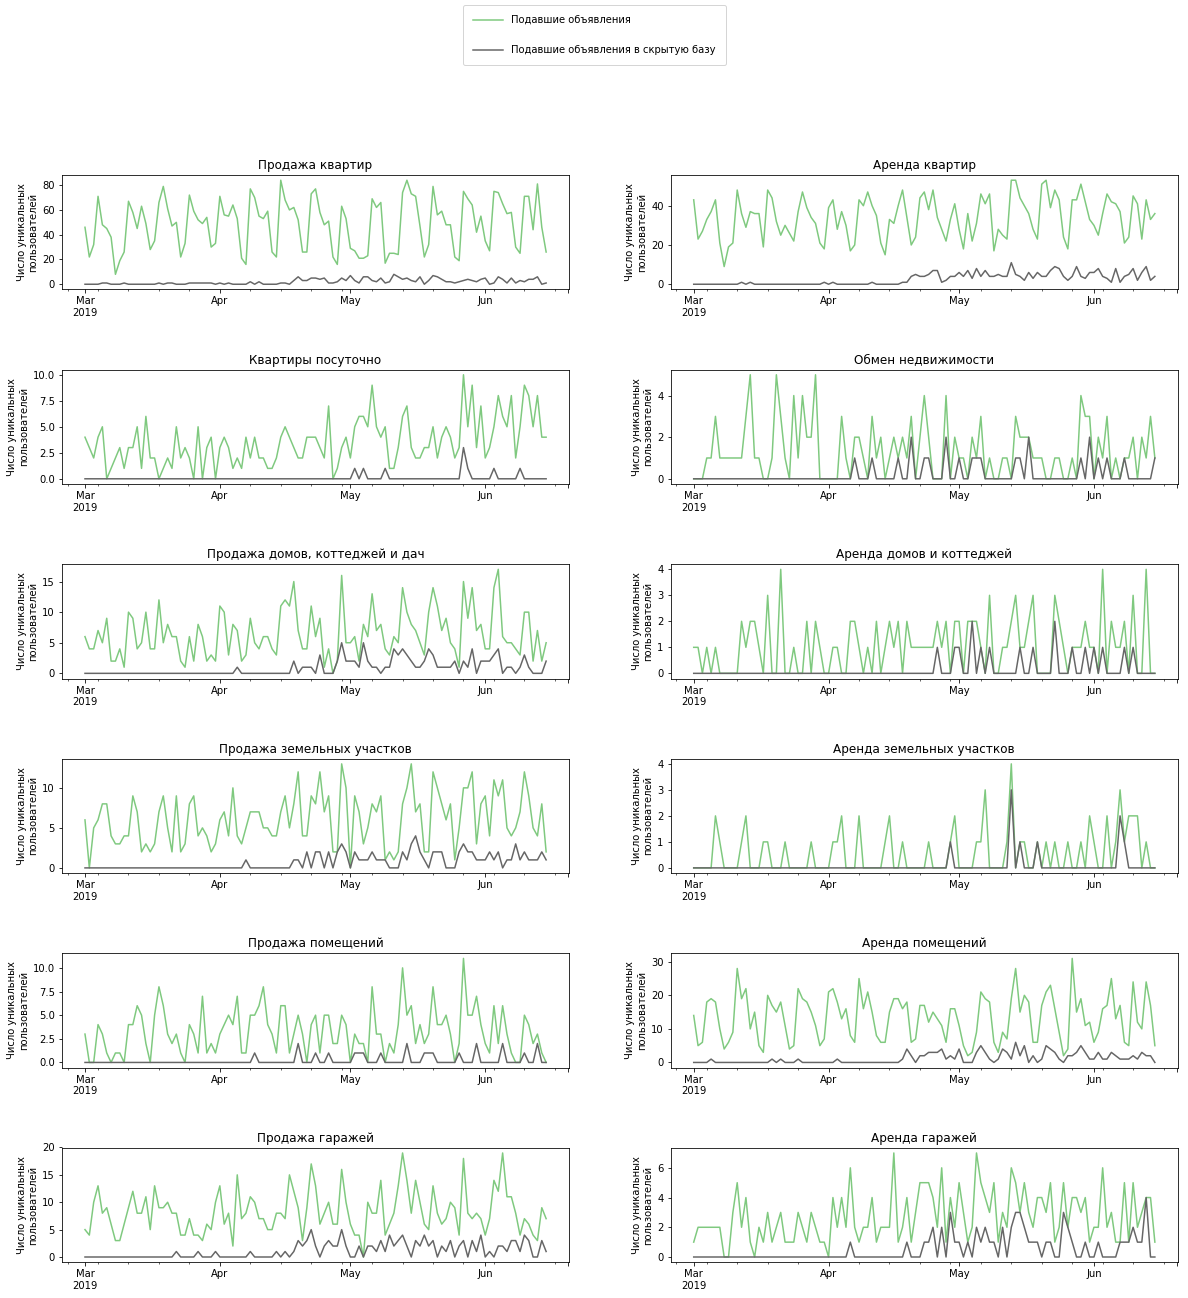

In [40]:
f, axes = plt.subplots(len(r_id), 2, figsize = (20, 20))

plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(len(r_id)):
    for j in range(2):
        rez[rez['id']==r_id[i][j]][['Подавшие объявления', 'Подавшие объявления в скрытую базу']].plot(ax=axes[i][j], title=title[i][j], legend=False, colormap='Accent')
        
        
        axes[i][j].set_xlabel(None)
        axes[i][j].set_ylabel('Число уникальных\nпользователей')
        
f.legend(['Подавшие объявления', 'Подавшие объявления в скрытую базу'], loc='upper center', handlelength=3, borderpad=1, labelspacing=2)
plt.show()

**Рисуем динамику по всей недвижимости (по данным с запроса realty)**

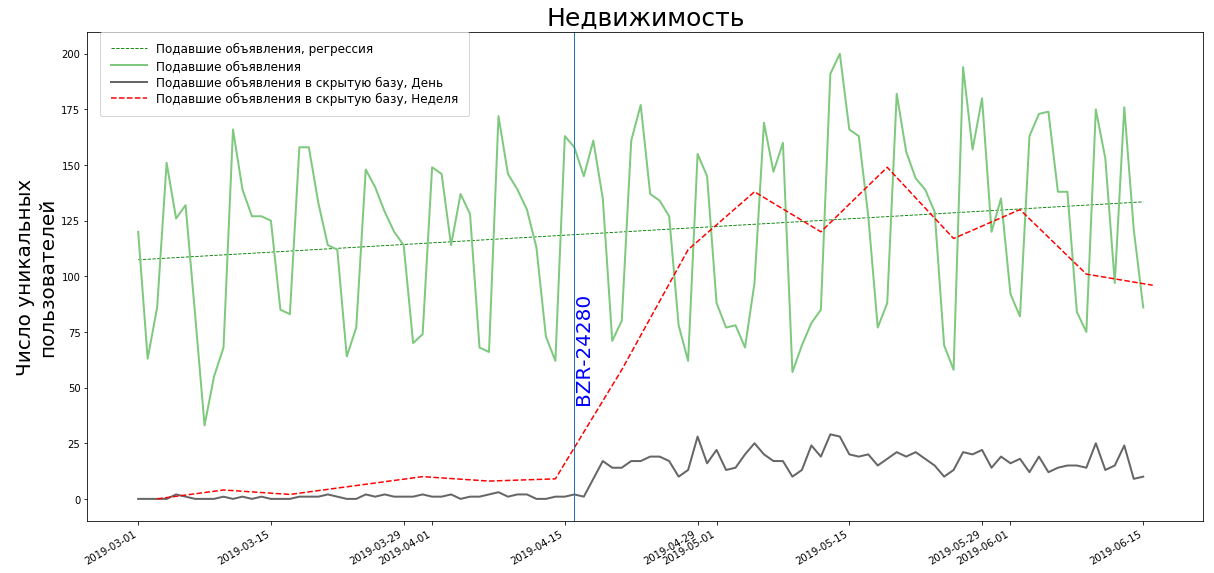

In [43]:
# Линейная регрессия
x = priv_base_num_all['user_cnt'].index.values.reshape(priv_base_num_all['user_cnt'].shape[0], 1)
y = priv_base_num_all['user_cnt'].values.reshape(priv_base_num_all['user_cnt'].shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)
# ---------------------------------------------------- plots

f, axes = plt.subplots(1, 1, figsize = (20, 10))

plt.plot(priv_base_num_all.index, regr.predict(x.astype(float)), color='g', linewidth=0.9, linestyle='--')

priv_base_num_all.plot(ax=axes, legend=False, title='Недвижимость', colormap='Accent', linewidth=2)
priv_base_num_all['priv_cnt'].resample('W').sum().plot(ax=axes, style='--', color='red')

# ----------------------------------------------------- settings
axes.axvline('2019-04-16', linewidth=1, linestyle='-')
plt.text('2019-04-16', 86, 'BZR-24280', rotation=90, fontsize=20, color='b')

axes.title.set_size(25)
axes.set_xlabel(None)
axes.set_ylabel('Число уникальных\nпользователей', fontsize=20)

plt.rcParams.update({'legend.fontsize': 12})

f.legend(['Подавшие объявления, регрессия',
          'Подавшие объявления',
          'Подавшие объявления в скрытую базу, День',
          'Подавшие объявления в скрытую базу, Неделя'],
         loc=1, bbox_to_anchor=(0.33, 0.76), handlelength=3, borderpad=0.9, labelspacing=0.3)

plt.show()

**Сводная таблица за период до и после изменений (до и после BZR-24280)**

In [58]:
def aggregate(df, mask):
    desc = df[mask].groupby(['id']).agg(['mean', 'sum'])

    desc.columns = desc.columns.droplevel(1)

    desc.columns = ['Подавшие объявления, среднее',
                    'Подавшие объявления, сумма',
                    'Подавшие объявления в скрытую базу, среднее',
                    'Подавшие объявления в скрытую базу, сумма']

    desc = pd.concat([desc, (desc['Подавшие объявления в скрытую базу, сумма']/desc[['Подавшие объявления, сумма', 'Подавшие объявления в скрытую базу, сумма']].sum(axis=1))*100], axis=1)

    pivot = desc.rename(columns={0: 'Процент скрытых ,%'}).merge(dirs, on='id', how='left')
    pivot.set_index('title', inplace=True)
    pivot.index.rename('Раздел', inplace=True)

    result = pivot[['Подавшие объявления, среднее',
                    'Подавшие объявления, сумма',
                    'Подавшие объявления в скрытую базу, среднее',
                    'Подавшие объявления в скрытую базу, сумма',
                    'Процент скрытых ,%']]
    
    return result

In [59]:
mask1 = priv_base_num_all.index<'2019-04-17'
mask2 = priv_base_num_all.index>='2019-04-17'

priv_sum1 = priv_base_num_all['priv_cnt'][mask1].sum()
all_sum1 = priv_base_num_all['user_cnt'][mask1].sum()

priv_sum2 = priv_base_num_all['priv_cnt'][mask2].sum()
all_sum2 = priv_base_num_all['user_cnt'][mask2].sum()

In [60]:
day_bull_average1 = priv_base_num_all['user_cnt'][mask1].mean()
day_priv_bull_average1 = priv_base_num_all['priv_cnt'][mask1].mean()

day_bull_average2 = priv_base_num_all['user_cnt'][mask2].mean()
day_priv_bull_average2 = priv_base_num_all['priv_cnt'][mask2].mean()

In [61]:
under = aggregate(rez, rez.index<'2019-04-17')
upper = aggregate(rez, rez.index>='2019-04-17')

th_props = [
    ('font-size', '15px'),
    ('text-align', 'center'),
    ('font-weight', 'bold'),
    ('color', '#6d6d6d'),
    ('background-color', '#f7f7f9')
    ]

td_props = [
    ('font-size', '18px')
    ]

styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

under.style.set_table_styles(styles)

,"Подавшие объявления, среднее","Подавшие объявления, сумма","Подавшие объявления в скрытую базу, среднее","Подавшие объявления в скрытую базу, сумма","Процент скрытых ,%"
Раздел,,,,,
Продажа квартир,48.0213,2257,0.425532,20,0.878349
Аренда квартир,31.7021,1490,0.106383,5,0.334448
Обмен недвижимости,1.42553,67,0.0425532,2,2.89855
Продажа помещений,3.19149,150,0.0212766,1,0.662252
Аренда помещений,13.4681,633,0.106383,5,0.783699
"Продажа домов, коттеджей и дач",5.59574,263,0.0212766,1,0.378788
Аренда домов и коттеджей,0.829787,39,0,0,0
Продажа земельных участков,5.17021,243,0.0212766,1,0.409836
Продажа гаражей,7.46809,351,0.12766,6,1.68067


In [57]:
upper.style.set_table_styles(styles)

,"Подавшие объявления, среднее","Подавшие объявления, сумма","Подавшие объявления в скрытую базу, среднее","Подавшие объявления в скрытую базу, сумма","Процент скрытых ,%"
Раздел,,,,,
Продажа квартир,48.6667,2920,3.36667,202,6.47021
Аренда квартир,35.8333,2150,4.68333,281,11.559
Обмен недвижимости,1.25,75,0.366667,22,22.6804
Продажа помещений,3.31667,199,0.35,21,9.54545
Аренда помещений,13.3333,800,2.03333,122,13.2321
"Продажа домов, коттеджей и дач",7.11667,427,1.58333,95,18.1992
Аренда домов и коттеджей,1.21667,73,0.283333,17,18.8889
Продажа земельных участков,6.78333,407,1.28333,77,15.9091
Продажа гаражей,8.86667,532,1.91667,115,17.7743


## 1.3 Сколько людей, которые никогда не подавали объявление в недвижимости, подали в скрытую базу

## 1.4 Cколько людей, которые зависали раньше на черновике в недвижимости, подали в скрытую базу

Под никогда понимаем: последние 5 лет

Т.е. с 14-го по 19-ый год никогда не подавали объявление/зависали в черновиках

*"Зависали в черновиках" означает, что пользователь заполнил объявление и не опубликовал его*

Первый запрос (users) выбирает всех пользователей за рассматриваемый период (после внедрения фичи).

После необходимо понять кто из данных пользователей не подавал объявления (исследуем период минус 5 лет):

Запросы bulletins и bulletins_archive выбирают последнюю дату черновика и объявления (т.е. дата крайней активности пользователя)

In [ ]:
cnx = mysql.connector.connect(option_files='/etc/my.cnf')
cursor = cnx.cursor()

users = f"""
    SELECT
    DISTINCT reg_user_id

    FROM bazar.bulletins
    
    WHERE dir IN ({str_ids})
    
        AND cityid = 1
    
        AND reg_user_id not in 
        (
        SELECT
            user_id
        FROM
            bazar.user_roles
        WHERE
            role = 'admin'
        )
    
        AND payment_status != 'paymentRequired'
        AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
        AND EXTRACTVALUE(attributes,'/attributes/attribute[@name="bulletin.isPrivate"]/@value') IN ('1' , 'true')
        
        AND date_created >= '2019-04-17 00:00:00'
        AND date_created <= '2019-06-15 23:59:59'
    """

cursor.execute(users)
user_id = pd.DataFrame([i for i in cursor], columns=['priv_user_id'])

In [ ]:
str_user_id = list(map(lambda x: str(x), user_id['priv_user_id']))

In [2200]:
def init_query(cursor, query, columns, parameters):
    cursor.execute(query, parameters)
    return pd.DataFrame([i for i in cursor], columns=columns)

In [2337]:
bulletins = '''
    SELECT 
    MAX(CASE WHEN payment_status = 'paymentRequired' THEN date_created ELSE NULL END) as maxDateDraft,
    MAX(CASE WHEN payment_status != 'paymentRequired' THEN date_created ELSE NULL END) as maxDateNotDraft

    FROM bazar.bulletins

    WHERE dir IN (%(dirs)s)
    
    AND cityid = 1
    AND reg_user_id = %(id)s    
    
    AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
        
    AND date_created >= '2014-01-01 00:00:00'
    AND date_created <= '2019-03-01 23:59:59'
    '''

bulletins_archive = '''
    SELECT 
    MAX(CASE WHEN payment_status = 'paymentRequired' THEN date_created ELSE NULL END) as maxDateDraft,
    MAX(CASE WHEN payment_status != 'paymentRequired' THEN date_created ELSE NULL END) as maxDateNotDraft

    FROM bazar.bulletins_archive

    WHERE dir IN (%(dirs)s)
    
    AND cityid = 1
    AND reg_user_id = %(id)s    
    
    AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
        
    AND date_created >= '2014-01-01 00:00:00'
    AND date_created <= '2019-03-01 23:59:59'
    '''

In [2338]:
cnx = mysql.connector.connect(option_files='/etc/my.cnf', database='bazar')
cursor = cnx.cursor()

bulletinsq = pd.concat([init_query(cursor, bulletins, ['maxDateDraft', 'maxDateNotDraft'],{'dirs': str_ids,'id': s}) for s in str_user_id], axis=0)
bulletins_archiveq = pd.concat([init_query(cursor, bulletins_archive, ['maxDateDraft', 'maxDateNotDraft'], {'dirs': str_ids,'id': s}) for s in str_user_id], axis=0)

In [2342]:
draft = pd.concat([bulletinsq['maxDateDraft'],bulletins_archiveq['maxDateDraft']], axis=1)
notdraft = pd.concat([bulletinsq['maxDateNotDraft'],bulletins_archiveq['maxDateNotDraft']], axis=1)

maxcntdraft = draft.apply(lambda x: pd.to_datetime(x)).max(axis=1).count()
maxcntnotdraft = notdraft.apply(lambda x: pd.to_datetime(x)).max(axis=1).count()

**В итоге:**

5.65 % пользователей, которые зависали раньше на черновиках, подали в скрытую базу.

86.7 % пользователей, которые никогда не подавали объявления в недвижимость, подали в скрытую базу.

In [2477]:
(maxcntdraft/len(str_user_id))*100

5.655296229802514

In [2369]:
(1 - maxcntnotdraft/len(str_user_id))*100

86.71454219030521

# 2. Что с датасетом ?

## 2. 1 Cтало ли меньше черновиков? 

Вытаскиваем черновики payment_status = 'paymentRequired'

Считаем их количество

In [2431]:
cnx = mysql.connector.connect(option_files='/etc/my.cnf')
cursor = cnx.cursor()

query = f"""

    SELECT
    
    DATE(date_created) AS dt, COUNT(reg_user_id)
    
    FROM bazar.bulletins
    
    WHERE dir IN ({str_ids})
    
    AND cityid = 1
    
    AND reg_user_id not in 
    (
        SELECT
            user_id
        FROM
            bazar.user_roles
        WHERE
            role = 'admin'
    )
    
    AND payment_status = 'paymentRequired'
    AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
    
    AND date_created >= '2019-01-01 00:00:00'
    AND date_created <= '2019-06-15 23:59:59'
    
    GROUP BY dt
    
    """
    
cursor.execute(query)
drafts = pd.DataFrame([i for i in cursor], columns=['date', 'cnt_user_id'])

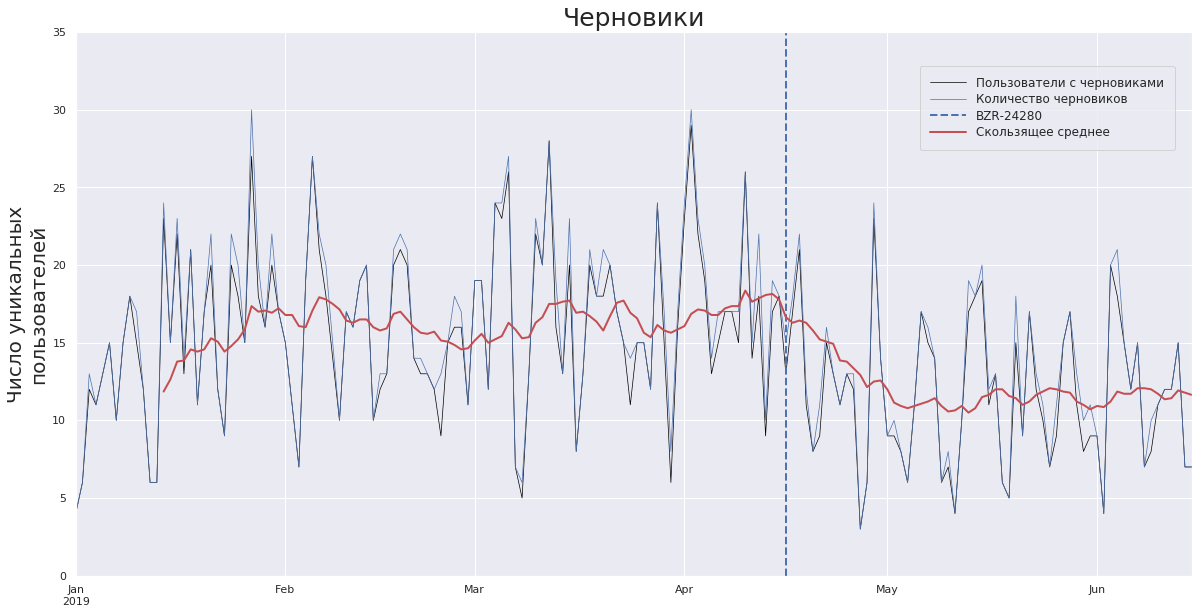

In [2688]:
f, axes = plt.subplots(1, 1, figsize = (20, 10))
plt.subplots_adjust(wspace=0.0, hspace=0.2)

drafts.plot(ax=axes, legend=False, color='000000', linewidth=0.7, title='Черновики')

drafts.index = pd.to_datetime(drafts.index)
drafts.rolling(window=14).mean().plot(ax=axes, legend=False, color='r', linewidth=2)

axes.axvline('2019-04-16', linewidth=2, linestyle='--')

axes.title.set_size(25)
axes.set_xlabel(None)
axes.set_ylabel('Число уникальных\nпользователей', fontsize=20)

axes.set_xlim(['2019-01-01', '2019-06-15'])
axes.set_ylim([0, 35])

f.legend(['Пользователи с черновиками',
          'Количество черновиков',
          'BZR-24280',
          'Скользящее среднее'],
         loc=1, bbox_to_anchor=(0.82, 0.77), handlelength=3, borderpad=0.9, labelspacing=0.3)

plt.show()

## 2.2 стало ли больше удаленных объявлений ?

Вытаскиваем удалённые объявления user_publish_status < 0

Считаем их количество по приватной и по всей базе

In [3014]:
import mysql.connector

cnx = mysql.connector.connect(option_files='/etc/my.cnf')
cursor = cnx.cursor()

for d in DATE:
    
    deletes = f"""
    
    select
        DATE(date_created) as dt,
        count(1) as all_created, 
        sum(user_publish_status < 0) as all_deleted,
        
        sum(EXTRACTVALUE(attributes,'/attributes/attribute[@name="bulletin.isPrivate"]/@value') IN ('1' , 'true')) as private_created, 
        sum(user_publish_status < 0 and EXTRACTVALUE(attributes,'/attributes/attribute[@name="bulletin.isPrivate"]/@value') IN ('1' , 'true')) as private_deleted 

FROM bazar.bulletins
    
WHERE dir IN ({str_ids})
    
        AND cityid = 1
    
        AND reg_user_id not in 
        (
        SELECT
            user_id
        FROM
            bazar.user_roles
        WHERE
            role = 'admin'
        )
    
        AND payment_status != 'paymentRequired'
        AND EXTRACTVALUE(attributes, '/attributes/attribute[@name="bulletin.is_valid"]/@value') IN ('1' , 'true')
        
        AND date_created >= '{DATE[d]} 00:00:00'
        AND date_created <= '{DATE[d]} 23:59:59'
        
group by dt
    """
    
    cursor.execute(deletes)
    pd.DataFrame([i for i in cursor], columns=['date', 'all_created', 'all_del', 'priv_created', 'priv_del']).to_csv('/home/starkov/FANS/FAN58/query6/' + DATE[d] + '.csv')

In [100]:
deleted = pd.concat([pd.read_csv('/home/starkov/FANS/FAN58/deleted/' + DATE[d] + '.csv') for d in DATE])

In [101]:
deleted.head(3)

,Unnamed: 0,date,all_created,all_del,priv_created,priv_del
0,0,2019-03-28,160,103,1,1
0,0,2019-03-29,154,96,1,0
0,0,2019-03-30,86,54,1,1


In [75]:
deleted.set_index('date', inplace=True)
deleted.index = pd.to_datetime(deleted.index)
deleted = deleted[['all_del', 'priv_del']]

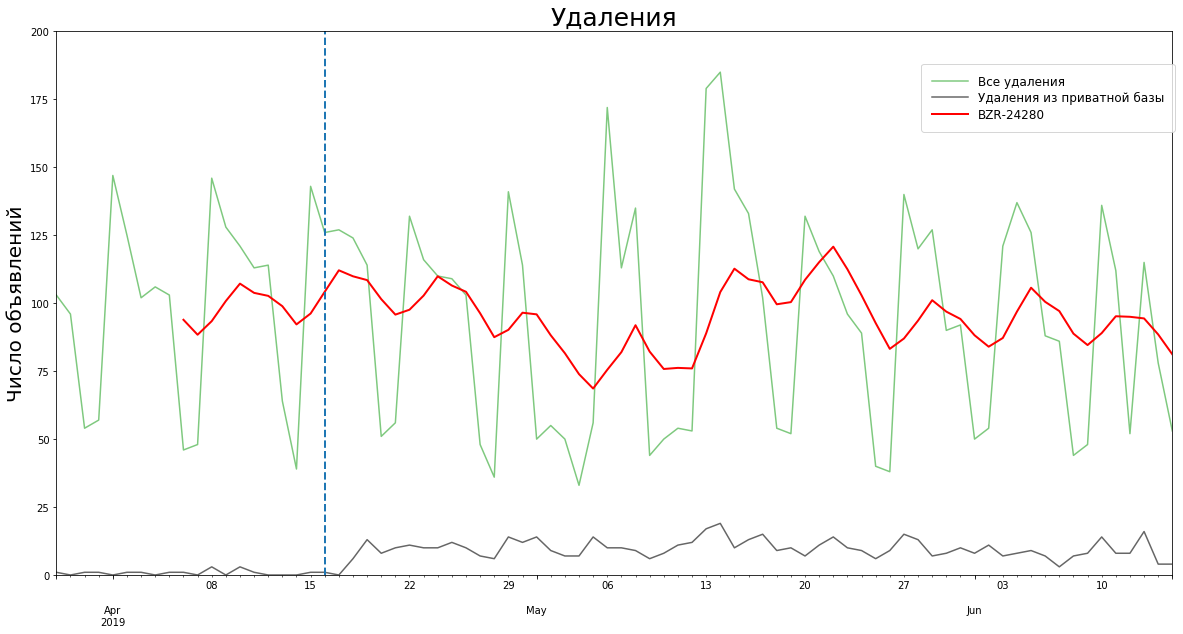

In [82]:
f, axes = plt.subplots(1, 1, figsize = (20, 10))

deleted.plot(ax=axes, legend=False, linewidth=1.5, title='Удаления', colormap='Accent')
deleted['all_del'].rolling(window=10).mean().plot(ax=axes, legend=False, color='r', linewidth=2)

axes.axvline('2019-04-16', linewidth=2, linestyle='--')


axes.title.set_size(25)
axes.set_xlabel(None)
axes.set_ylabel('Число объявлений', fontsize=20)

axes.set_xlim(['2019-03-28', '2019-06-15'])
axes.set_ylim([0, 200])

f.legend(['Все удаления',
          'Удаления из приватной базы',
          'BZR-24280'],
         loc=1, bbox_to_anchor=(0.82, 0.8), handlelength=3, borderpad=0.9, labelspacing=0.3)

plt.show()

# 3. Что с агентами

## 3.1 Звонят ли по объявлениям, какая конверсия ?

Данные берём из логов в clickhouse

Необходимо получить конверсии из раздела в объявления и из объявления в контакты по скрытой базе

В результате запроса получаем таблицу с числом переходов из раздела в объявления и числом переходов из объявления в контакты

Основная сложность заключается в том, что посещение объявления должно быть позже посещения раздела;
показ контактов должен быть позже объявления

In [3560]:
import os, sys
sys.path.append(u'/home/starkov/projects/scripts/Common')

from DB_driver import Clickhouse

In [3561]:
settings = {'max_block_size': 100000}
clh = Clickhouse('clickhouse-n1.bazadev.net', settings=settings)

In [103]:
datelist = pd.date_range(start='2019-05-01', end='2019-06-20').strftime("%Y-%m-%d").tolist()
DATE = dict(enumerate(datelist))

In [3491]:
def func(df):
    return pd.DataFrame({
        'agent_type': [df[df['agent_type']=='privatePerson']['agent_type'].count()>0],
        'viewbull': [df[df['is_viewbull']==True]['viewbull_id'].nunique()],
        'viewbull&cont': [df[(df['is_viewbull']==True) & (df['is_contact']==True)]['viewbull_id'].nunique()]
    })

In [3869]:
for d in DATE:

    notify = f"""
        SELECT

        datetime,
        userid,
        isViewDir,
        isViewBull,
        case when isViewDir then cutQueryStringAndFragment(url) when isViewBull then path(referrer) else '' end as dir_path,
        case when isViewBull then extract(url, '([0-9]+)[.]html') when isContact then extract(referrer, '([0-9]+)[.]html') else '' end as viewbull_id,
        extractURLParameter(url, 'agentType%5B%5D') as agent_type

        from bazalogs.access_log

        where date = '{DATE[d]}'
          and is_bot = 0
          and ring not in ('', 'NULL', 'deleted')
          and clientip_ipv4 not in (1603955675, 1836989970)
          and userid > 0
          and host = 'www.farpost.ru'
          and (
            (
              (
                controller = 'viewDirController::view' and
                match(url, '^/vladivostok/realty/.*[?&]privateBulletinFilter(%5B[0-9]*%5D)?=1')
              ) as isViewDir
            ) or (
              (
                controller = 'viewBullController::viewBullSeo' and
                match(referrer, '/vladivostok/realty/.*[?&]privateBulletinFilter(%5B[0-9]*%5D)?=1')
              ) as isViewBull
            ) or (
              (
                (url like '/mmy.txt?action=viewbull-action%keyName=click-show-contacts%'
                or url like '/mmy.txt?action=viewbull\\_action\\_bulletin&keyName=show-contacts%')
                and match(referrer, '/vladivostok/realty/.*[0-9]+[.]html')
              ) as isContact
            )
          )
        """

    bulls = clh.pd_execute_iter(notify, columns=['datetime', 'userid', 'isViewDir', 'isViewBull', 'dir_path', 'viewbull_id', 'agent_type'])
    
    viewbull = bulls[bulls['isViewBull']==1]
    viewdir = bulls[bulls['isViewDir']==1]
    contacts = bulls[(bulls['isViewDir']==0) & (bulls['isViewBull']==0)]

    if viewdir.shape[0] > 0:

        in_viewbull = viewbull.merge(contacts, on=['userid', 'viewbull_id'], how='left')

        if viewbull.shape[0] > 0:

            in_viewbull['is_contact'] = in_viewbull.datetime_y.notna() & (in_viewbull.datetime_y > in_viewbull.datetime_x)

            in_viewbull_grp = in_viewbull.groupby(['datetime_x', 'userid', 'dir_path_x', 'viewbull_id']).apply(lambda x: x['is_contact'].sum()>0).reset_index()
            in_viewbull_grp.columns = ['datetime', 'userid', 'dir_path', 'viewbull_id', 'is_contact']

        else: pass

        rez = viewdir.merge(in_viewbull_grp, on=['userid', 'dir_path'], how='left')
        rez['is_viewbull'] = rez.datetime_y.notna() & (rez.datetime_y > rez.datetime_x)

        rez.rename(columns={'viewbull_id_y':'viewbull_id'}, inplace=True)

        rezgrp = rez.groupby(['userid', 'dir_path']).apply(func)
        rezgrp.reset_index(inplace=True)
        
        rezgrp['date'] = DATE[d]
        
        rezgrp.drop(rezgrp.columns[2], axis=1).to_csv('/home/starkov/FANS/FAN58/clh/' + DATE[d] + '.csv')

    else: pass

In [145]:
bulls = pd.concat([pd.read_csv('/home/starkov/FANS/FAN58/clh/' + DATE[d] + '.csv') for d in DATE])

In [105]:
bulls.head()

,Unnamed: 0,userid,dir_path,agent_type,viewbull,viewbull&cont,date
0,0,217,/vladivostok/realty/,False,0,0,2019-05-01
1,1,217,/vladivostok/realty/sell_flats/,False,2,1,2019-05-01
2,2,798,/vladivostok/realty/,False,6,0,2019-05-01
3,3,888,/vladivostok/realty/,False,4,1,2019-05-01
4,4,1319,/vladivostok/realty/,False,0,0,2019-05-01


**Конверсии + Доверительные интервалы**

In [91]:
def wilson_score(a, N, confidence, digits):
    """
    a - number of successes
    N - total number of trials
    confidence - confidence interval
    
    return Wilson Score Interval
    """
    
    if N == 0:
        return 0
    
    #percent point function
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    p = 1.0 * a / N
    
    upper = (p + z * z / (2 * N) + z * math.sqrt((p * (1 - p) + z * z / (4 * N)) / N)) / (1 + z * z / N)
    lower = (p + z * z / (2 * N) - z * math.sqrt((p * (1 - p) + z * z / (4 * N)) / N)) / (1 + z * z / N)
    
    return [round(lower*100, digits), round(upper*100, digits)]

In [92]:
def conversion(df):
    return pd.DataFrame({
        'viewbull': [round(100*(df[df['viewbull']>0]['userid'].nunique()/df['userid'].nunique()), 2)],
        'viewbull&cont': [round(100*df[df['viewbull&cont']>0]['userid'].nunique()/df['userid'].nunique(), 2)]
    })

In [93]:
def conv_intervals(df):
    return pd.DataFrame({
        'viewbull': wilson_score(df[df['viewbull']>0]['userid'].nunique(), df['userid'].nunique(), 0.95, 2),
        'viewbull&cont': wilson_score(df[df['viewbull&cont']>0]['userid'].nunique(), df['userid'].nunique(), 0.95, 2)
    })

In [94]:
def index_settings(df):
    
    df.reset_index(inplace=True)
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)

## Вся недвижимость

In [96]:
# Вычисляем конверсии
conv = bulls.groupby('date').apply(conversion)

index_settings(conv)
conv.drop(conv.columns[0], axis=1, inplace=True)

# Вычисляем доверительные интервалы для конверсий
ci = bulls.groupby('date').apply(conv_intervals)

index_settings(ci)

# Сверху и снизу для объявлений
viewbull_intervals = pd.concat([ci[ci['level_1']==0]['viewbull'],
                      ci[ci['level_1']==1]['viewbull']], axis=1)

viewbull_intervals.columns=['under', 'upper']


# Сверху и снизу для контактов
contact_intervals = pd.concat([ci[ci['level_1']==0]['viewbull&cont'],
                     ci[ci['level_1']==1]['viewbull&cont']], axis=1)

contact_intervals.columns=['under', 'upper']

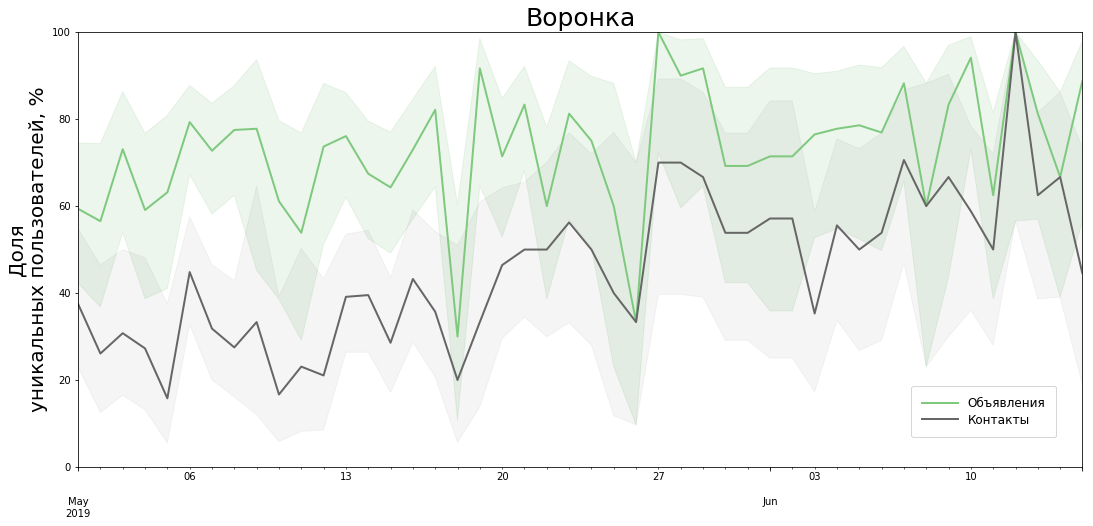

In [97]:
f, axes = plt.subplots(1, 1, figsize = (18, 8))

conv.plot(ax=axes, legend=False, linewidth=2, title='Воронка', colormap='Accent')

axes.fill_between(viewbull_intervals.index, viewbull_intervals['under'], viewbull_intervals['upper'], color = 'g', alpha = 0.07, label = '95% CI')
axes.fill_between(contact_intervals.index, contact_intervals['under'], contact_intervals['upper'], color = '000000', alpha = 0.04, label = '95% CI')


axes.title.set_size(25)

axes.set_xlabel(None)
axes.set_ylabel('Доля\nуникальных пользователей, %', fontsize=20)

axes.set_xlim(['2019-05-01', '2019-06-15'])
axes.set_ylim([0, 100])

plt.legend(['Объявления',
          'Контакты',],
             loc=1, bbox_to_anchor=(0.98, 0.2), handlelength=3, borderpad=0.9, labelspacing=0.3)

plt.show()

## Аренда и продажа квартир

In [106]:
# Оставляем только последний кусок раздела
bulls['dir_path'] = bulls['dir_path'].str.extract(r'/([a-zA-Z_]+)/$')

In [107]:
# Делим на продажу и аренду

sell = bulls[bulls['dir_path']=='sell_flats']
rent = bulls[bulls['dir_path']=='rent_flats']

In [108]:
sell_conv = sell.groupby('date').apply(conversion)

index_settings(sell_conv)
sell_conv.drop(sell_conv.columns[0], axis=1, inplace=True)

In [109]:
rent_conv = rent.groupby('date').apply(conversion)

index_settings(rent_conv)
rent_conv.drop(rent_conv.columns[0], axis=1, inplace=True)

In [111]:
# Доверительные интервалы для продажи/аренды

sell_intervals = sell.groupby('date').apply(conv_intervals)

index_settings(sell_intervals)

# Разделяем на объявления и контакты
viewbullSell = pd.concat([sell_intervals[sell_intervals['level_1']==0]['viewbull'],
                          sell_intervals[sell_intervals['level_1']==1]['viewbull']], axis=1)

contactSell = pd.concat([sell_intervals[sell_intervals['level_1']==0]['viewbull&cont'],
                         sell_intervals[sell_intervals['level_1']==1]['viewbull&cont']], axis=1)

viewbullSell.columns=['under', 'upper']
contactSell.columns=['under', 'upper']

In [113]:
rent_intervals = rent.groupby('date').apply(conv_intervals)

index_settings(rent_intervals)

# Доверительные интервалы для Аренды
viewbullRent = pd.concat([rent_intervals[rent_intervals['level_1']==0]['viewbull'],
                          rent_intervals[rent_intervals['level_1']==1]['viewbull']], axis=1)

viewbullRent.columns=['under', 'upper']

contactRent = pd.concat([rent_intervals[rent_intervals['level_1']==0]['viewbull&cont'],
                         rent_intervals[rent_intervals['level_1']==1]['viewbull&cont']], axis=1)

contactRent.columns=['under', 'upper']

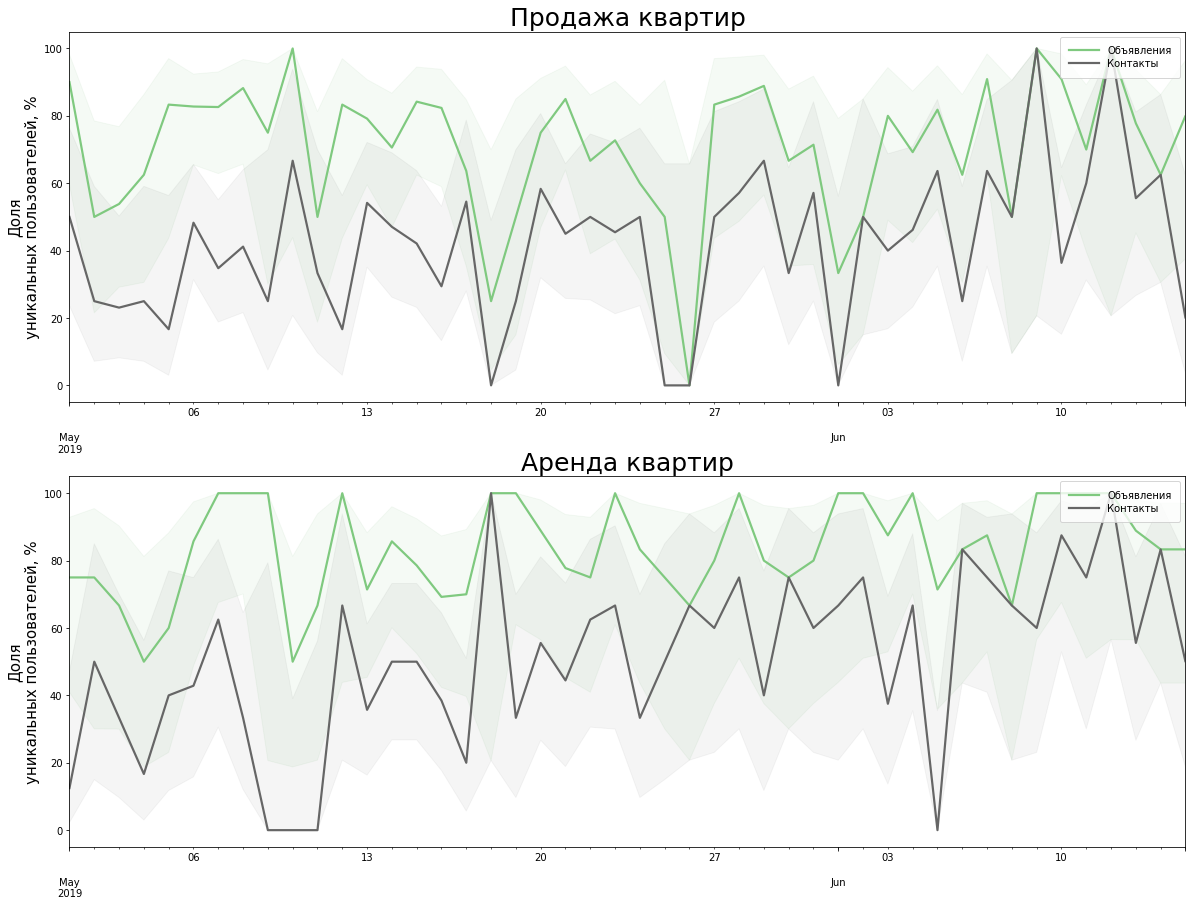

In [116]:
f, axes = plt.subplots(2, 1, figsize = (20, 15))

plt.subplots_adjust(wspace=0.2, hspace=0.2)

sell_conv.plot(ax=axes[0], legend=False, colormap='Accent', linewidth=2.2)
rent_conv.plot(ax=axes[1], legend=False, colormap='Accent', linewidth=2.2)

axes[0].set_title('Продажа квартир', fontsize=25)
axes[0].fill_between(viewbullSell.index, viewbullSell['under'], viewbullSell['upper'], color = 'g', alpha = 0.04, label = '95% CI')
axes[0].fill_between(contactSell.index, contactSell['under'], contactSell['upper'], color = '000000', alpha = 0.04, label = '95% CI')

axes[1].set_title('Аренда квартир', fontsize=25)    
axes[1].fill_between(viewbullRent.index, viewbullRent['under'], viewbullRent['upper'], color = 'g', alpha = 0.04, label = '95% CI')
axes[1].fill_between(contactRent.index, contactRent['under'], contactRent['upper'], color = '000000', alpha = 0.04, label = '95% CI')
 
for ax in axes:
    
    ax.set_xlabel(None)
    ax.set_ylabel('Доля\nуникальных пользователей, %', fontsize=15)
    
    ax.set_xlim(['2019-05-01', '2019-06-15'])
    
    ax.legend(['Объявления',
               'Контакты'],
              loc=1, bbox_to_anchor=(1, 1), handlelength=3, borderpad=0.9, labelspacing=0.3, fontsize=10) 

# Итоговая таблица с конверсиями

In [146]:
# Вся недвижимость
realty_convs = conversion(bulls)
realty_intervals = conv_intervals(bulls)

realty = pd.concat([realty_convs, realty_intervals], axis=0).astype(str)

In [147]:
# Продажа
sell_convs = conversion(sell)
sell_intervals = conv_intervals(sell)

sells = pd.concat([sell_convs, sell_intervals], axis=0).astype(str)

In [148]:
# Аренда
rent_convs = conversion(rent)
rent_intervals = conv_intervals(rent)

rents = pd.concat([rent_convs, rent_intervals], axis=0).astype(str)

In [149]:
sf = bulls[(bulls['dir_path']=='sell_flats') | (bulls['dir_path']=='rent_flats')]
sb = bulls[(bulls['dir_path']=='sell_business_realty') | (bulls['dir_path']=='rent_business_realty')]

In [150]:
bulls['dir_path'] = bulls['dir_path'].str.replace(r'/office/|/terminal/$', '')
bulls['dir_path'] = bulls['dir_path'].str.extract(r'/([a-zA-Z_]+)/$')

In [151]:
bulls['dir_path'] = bulls['dir_path'].replace('dacha', 'sell_houses')

In [152]:
convs_other_dirs = bulls.groupby('dir_path').apply(conversion).reset_index()
intervals_other_dirs = bulls.groupby('dir_path').apply(conv_intervals).reset_index()

convs_other_dirs['level_1'] = 3

In [153]:
table = pd.concat([convs_other_dirs, intervals_other_dirs], axis=0, sort=False)

In [155]:
table.head()

,dir_path,level_1,viewbull,viewbull&cont
0,exchange,3,50.00,0.00
1,flat_wanted,3,33.33,0.00
2,land,3,44.44,11.11
3,realty,3,48.59,21.47
4,rent_business_realty,3,75.00,50.00
